In [19]:
import numpy as np
import pandas as pd
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
rc_params = {
    'legend.fontsize': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16}
plt.rcParams.update(rc_params)

data_path = "data"

# 1. INTRODUCTION


huge amount of data
    

<b> check data </b><br>
$ ls -lh ./data
187M  2019 sample_submission.csv <br>
824M Dec 12  2019 test.csv <br>
2.5G Dec 12  2019 test_supplement.csv <br>
7.1G Dec 12  2019 train.csv <br>
3.9M Dec 12  2019 train_sample.csv <br>

$ cat train.csv | wc -l<br>
184903891

$ cat test.csv | wc -l<br>
18790470



use gc (garbage collector). I woulc be better to  delete constantly unncessary things.<br>
use dask instead of pandas <br>
read csv chunk by chunk or use feather <br>
use appropriate dyteps while reading file columns to reduce memory usage <br>



# 2. EDA

### 2.1 train_sample dataset

glimpse the sample train dataset to see data, fields, etc.

In [2]:
train_sample_df = pd.read_csv(os.path.join(data_path, "train_sample.csv"))
train_sample_df.head()    

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [3]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [4]:
train_sample_df['click_time'].min(), train_sample_df['click_time'].max()

('2017-11-06 16:00:00', '2017-11-09 15:59:51')

In [5]:
value_counts = train_sample_df['is_attributed'].value_counts()
value_counts

0    99773
1      227
Name: is_attributed, dtype: int64

In [6]:
round(100 * (value_counts.iloc[1] / len(train_sample_df)),3)

0.227

### 2.2 test dataset

In [8]:
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
test_df.head()   

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   click_id    int64 
 1   ip          int64 
 2   app         int64 
 3   device      int64 
 4   os          int64 
 5   channel     int64 
 6   click_time  object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB


In [10]:
test_df['click_time'].min(), test_df['click_time'].max()

('2017-11-10 04:00:00', '2017-11-10 15:00:00')

### 2.3 Descriptive stats

In [11]:
train_sample_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [12]:
test_df.describe()

,click_id,ip,app,device,os,channel
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02


<b> Comment </b><br> 
1. attributed_time empty and not in test: remove unused column 

2. pandas assign int64 to all integers,  correct dtype can be specified while loading data to reduce memory usage <br>.
int8 can store integers from -128 to 127.
int16 can store integers from -32768 to 32767.<br>
    
    * is_attributed is either 0 or 1, so it can bes cast to uint8<br>
    * channel changes between (0,498), so it can bes cast to uint16<br>
    
3. testset includes data from only at 2017-11-10. Morever, minutes&seconds could be removed from click_time, even tough they might give an idea about fraud movements. Hoever, .... A very large number of clicks from the same IP in a very short time can be used for fraud detection. <br>

4. it is not posibbile to read all train data due to hardrwade limitation. I need to sample it (~4M). On the other hand, fraudelent attributes are %0.22 of sampled train data. it seems highly unbalanced. Therefore it is better to read all fraud attirbuted value.

### 2.3 train dataset (all positive attributes and sampled negative attributes)

In [14]:
dtypes = {
    'ip'            : 'uint32', # changes between [0,364757] in sampled train dataset and test dataset
    'app'           : 'uint16', # changes between [0,511] in sampled train dataset and test dataset
    'device'        : 'uint16', # changes between [0,3867] in sampled train dataset and test dataset
    'os'            : 'uint16', # changes between [0,866] in sampled train dataset and test dataset
    'channel'       : 'uint16', # changes between [0,498] in sampled train dataset and test dataset
    'is_attributed' : 'uint8'   # binary variable
}
usecols = ['ip', 'app', 'device', 'os', 'channel','is_attributed', 'click_time']

chunksize = 4*(10**6)
neg_sample_size = chunksize // (180*(10**6)// chunksize)


train_df_list = []
for chunked_df in  pd.read_csv(os.path.join(data_path, "train.csv"), dtype=dtypes, usecols=usecols, chunksize=chunksize):
    train_df_list.append(chunked_df[chunked_df['is_attributed']==1])
    train_df_list.append(chunked_df[chunked_df['is_attributed']==0].sample(n=neg_sample_size))
    
    print(chunked_df['is_attributed'].value_counts())
    print("-"*12)
    
    del chunked_df
    gc.collect()

train_df = pd.concat(train_df_list)
train_df.describe()

0    3993058
1       6942
Name: is_attributed, dtype: int64
------------
0    3991802
1       8198
Name: is_attributed, dtype: int64
------------
0    3991750
1       8250
Name: is_attributed, dtype: int64
------------
0    3988062
1      11938
Name: is_attributed, dtype: int64
------------
0    3985864
1      14136
Name: is_attributed, dtype: int64
------------
0    3989093
1      10907
Name: is_attributed, dtype: int64
------------
0    3990748
1       9252
Name: is_attributed, dtype: int64
------------
0    3989739
1      10261
Name: is_attributed, dtype: int64
------------
0    3989236
1      10764
Name: is_attributed, dtype: int64
------------
0    3987414
1      12586
Name: is_attributed, dtype: int64
------------
0    3989836
1      10164
Name: is_attributed, dtype: int64
------------
0    3988283
1      11717
Name: is_attributed, dtype: int64
------------
0    3988109
1      11891
Name: is_attributed, dtype: int64
------------
0    3990202
1       9798
Name: is_attributed, dtyp

,ip,app,device,os,channel,is_attributed
count,4.634582e+06,4.634582e+06,4.634582e+06,4.634582e+06,4.634582e+06,4.634582e+06
mean,9.811669e+04,1.371729e+01,2.253174e+01,2.283475e+01,2.622880e+02,9.857329e-02
std,7.709684e+04,1.821613e+01,2.549498e+02,5.521533e+01,1.296483e+02,2.980883e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.194500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,8.291500e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.450000e+02,0.000000e+00
75%,1.238960e+05,1.800000e+01,1.000000e+00,1.900000e+01,3.770000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.223000e+03,8.860000e+02,4.980000e+02,1.000000e+00


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634582 entries, 103 to 184555976
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ip             uint32
 1   app            uint16
 2   device         uint16
 3   os             uint16
 4   channel        uint16
 5   click_time     object
 6   is_attributed  uint8 
dtypes: object(1), uint16(4), uint32(1), uint8(1)
memory usage: 128.2+ MB


In [16]:
value_count = train_df['is_attributed'].value_counts()
fraud_attributes =  100 * (value_count.iloc[1]) / 184903891
print("fraud %.2f %%\nnormal %.2f %%" % (fraud_attributes, 100-fraud_attributes))

fraud 0.25 %
normal 99.75 %


<b>Comment:</b> <br>
    1. even in whole train dataset fraud ratio is highly less %0.25 very close to sampled train dataset<br>
    2. value range is also very similar, dtpes settings ok


### 2.4 analysis of target variable

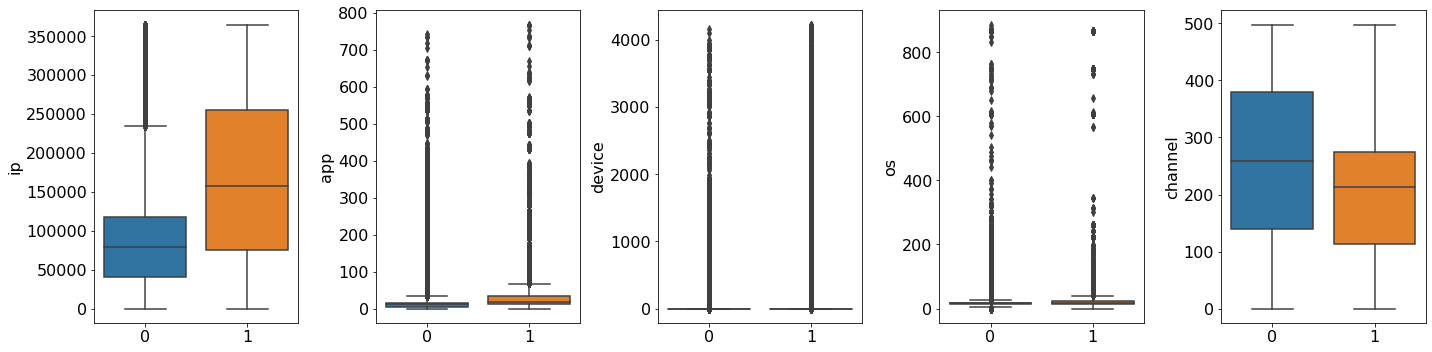

In [20]:
cols = ['ip', 'app', 'device', 'os', 'channel']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(20, 5))
for ix, col_name in enumerate(cols): 
    ax = axes[ix] 
    sns.boxplot(x='is_attributed', y=col_name, data=train_df, ax=ax)
    ax.set_ylabel(col_name) 
    ax.set_xlabel('') 
fig.tight_layout()

In [ ]:
cols = ['ip', 'app', 'device', 'os', 'channel']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(20, 5))
for ix, col_name in enumerate(cols): 
    ax = axes[ix] 
    sns.displot(data=train_df, x=col_name, hue='is_attributed', ax=ax, kind="kde")
    ax.set_ylabel('') 
    ax.set_xlabel(col_name) 
fig.tight_layout()

<b>Comment:</b> ip, os, channel distburibution is almost identical for both class. But app and device different